In [1]:
import os
import re
import itertools
import datetime
import math
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

Playing with the written statements from the Expressive Writing study. 

sources:
https://www.kaggle.com/dskswu/topic-modeling-bert-lda - topic modeling bert+lda

Specify path to input directory and read in files.

In [2]:
home = 0
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    writing_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements"
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"



In [3]:
for dirname, _, filenames in os.walk(writing_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ew_files = [f for f in filenames if 'T1' in f]
ewre_files = [f for f in filenames if 'T2' in f]
ctr_files = [f for f in filenames if 'T3' in f]


P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day3.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day4.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day3.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day4.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day3.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day4.csv


utils

In [4]:
def get_diaries(directory,filenames,group_name):
    """ 
    read in files from each group/day of writing
    in: path to input directory, list of filenames, condition name (EW, EWRE or CTR)
    out: list of lists of data from all days of writing for the specified group.
    """
    all_files = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2])
        # retain only records of people who finished the survey
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        # what day of writing were they on
        diary_df['day'] = i+1
        diary_df['Group'] = group_name
        writing_col = diary_df.filter(like = 'Please use the box below').columns[0]
        diary_df = diary_df.rename(columns = {writing_col: 'writing'})
        id_col = diary_df.filter(like = 'participant ID').columns[0]
        diary_df = diary_df.rename(columns = {id_col: 'id'})
        all_files.append(diary_df)
    return all_files

def read_files(infiles):
    """
    convert list of lists to dataframe.
    in: list of lists (output from get_diaries) 
    """
    all_df = pd.concat([pd.DataFrame(infiles[0]), pd.DataFrame(infiles[1]),pd.DataFrame(infiles[2]),pd.DataFrame(infiles[3])])
    return all_df

preprocessing

In [ ]:

from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
import pkg_resources
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# normalization
def func_norm(s):
    """
    Some basic normalisation.
    in: input string
    out: normalised string.
    
    """
    s = s.lower() # lower case
    # letter repetition (>2)
    s  = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # non word repetition
    s = s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # noise text
    s = re.sub(r' ing ', ' ', s)
    # phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def func_punc(w_list):
    """
    in: word list (w_list) to be processed
    out: w_list with punctuation and number filter out
    """
    return [word for word in w_list if word.isalpha()]

def func_stopf(w_list):
    """
    filter stop words
    in:  word list
    out: word list w/o stop words
    """
    stop_words = set(stopwords.words('english'))
    w_list  = [f for f in w_list if f not in stop_words]
    return w_list

# stemming
pstem = PorterStemmer()

def func_stem(w_list):
    """
    stem word list
    in: word list for stemming
    out: stemmed word list 
    """
    sw_list = [pstem.stem(w) for w in w_list]
    return sw_list

# selecting nouns
def func_noun(w_list):
    """
    in: word list to be processed
    out: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

# spell checker/typo correction
def func_spell(w_list):
    """
    in: word list to be processed
    out: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
    return w_list_fixed

def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw texts
    in: text to be processed
    out: sentence level pre-processed text
    """
    s = func_norm(rw)

    return s



def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    (remove punctuation, select noun, fix typo, stem, stop_words)
    in: sentence to be processed
    out: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = func_punc(w_list)
    w_list = func_noun(w_list)
   # w_list = func_spell(w_list)
    w_list = func_stem(w_list)
    w_list = func_stopf(w_list)

    return w_list

def preprocess(docs):
    """
    Preprocess the data
    """
    print('Preprocessing raw texts ...')
    #n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    #samp = np.random.choice(n_docs)
    for i in range(0, len(docs)):
        sentence = preprocess_sent(docs.iloc[i])
        token_list = preprocess_word(sentence)
        if token_list:
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(writing_df.writing) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists

Read in the diary files and compile them into a single dataframe.

In [5]:
all_ew = get_diaries(writing_dir, ew_files,'EW')
ew_df = read_files(all_ew)
all_ewre = get_diaries(writing_dir, ewre_files,'EWRE')
ewre_df = read_files(all_ewre)
all_ctr = get_diaries(writing_dir, ctr_files,'CTR')
ctr_df = read_files(all_ctr)
writing_df = pd.concat([ew_df,ewre_df,ctr_df])


# save if needed
save = 0
if save:
    writing_df.to_csv(os.path.join(writing_dir, 'writing_df.csv'))


Let's check whether we have roughly the same number of statements in each condition. We sort of know this is true, but nice to have a quick visual confirmation.

[Text(0, 0.5, 'Number of statements'), Text(0.5, 1.0, 'Statements per Group')]

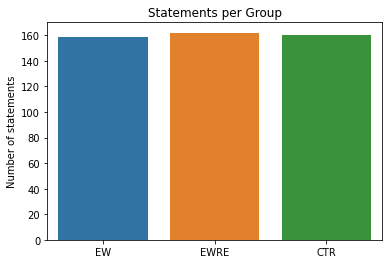

In [133]:
sns.barplot(x = writing_df.Group.unique(), y = [len(ew_df),len(ewre_df),len(ctr_df)]).set(ylabel = 'Number of statements', title = 'Statements per Group')

We'll now have a look at the top 50 words in each group before doing any preprocessing on the text.

Text(0.5, 1.0, 'CTR')

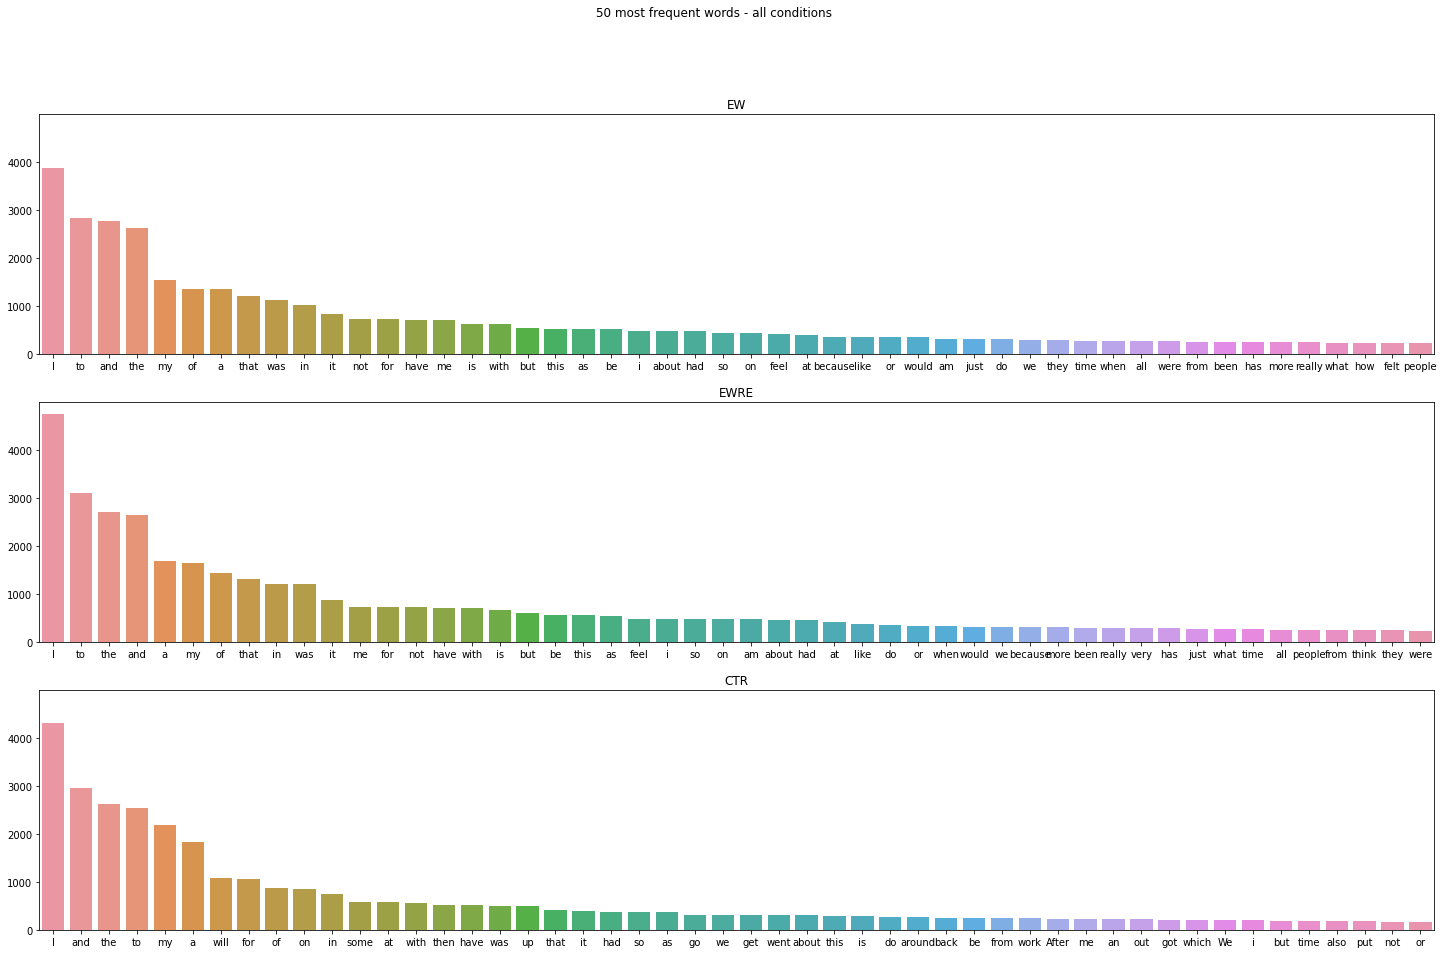

In [134]:
ew_words = writing_df.loc[writing_df.Group == 'EW','writing'].str.split(expand=True).unstack().value_counts()
ewre_words = writing_df.loc[writing_df.Group == 'EWRE','writing'].str.split(expand=True).unstack().value_counts()
ctr_words = writing_df.loc[writing_df.Group == 'CTR', 'writing'].str.split(expand = True).unstack().value_counts()

fig, axes = plt.subplots(3, 1, figsize=(25,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=ew_words.index[:50], y=ew_words[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=ewre_words.index[:50], y=ewre_words[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=ctr_words.index[:50], y=ctr_words[:50])
axes[2].set_title('CTR')

Even without having done any preprocessing, we can tell there is a difference between the active and control conditions. The word 'feel' makes the top 50 for both EW and EW+RE, but not for CTR, as does the word 'because'. 'Not' is also near the top of the list in both EW and EW+RE, whilst being last on the list of top 50 words in CTR. We will now do some preprocessing and then have another look.

In [10]:
sentences, token_lists = preprocess(writing_df.writing)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


We now draw up the same plot as before, but this time we look at the list of words for each group, from all days of writing.

In [135]:
writing_df = writing_df.reset_index(drop = False)
ew_inds = writing_df[writing_df.Group=='EW'].index
ewre_inds = writing_df[writing_df.Group == 'EWRE'].index
ctr_inds = writing_df[writing_df.Group =='CTR'].index
ew_flattened = [item for sublist in token_lists[ew_inds[0]:ew_inds[len(ew_inds)-1]] for item in sublist]
ewre_flattened = [item for sublist in token_lists[ewre_inds[0]:ewre_inds[len(ewre_inds)-1]] for item in sublist]
ctr_flattened = [item for sublist in token_lists[ctr_inds[0]:ctr_inds[len(ctr_inds)-1]] for item in sublist]

Text(0.5, 1.0, 'CTR')

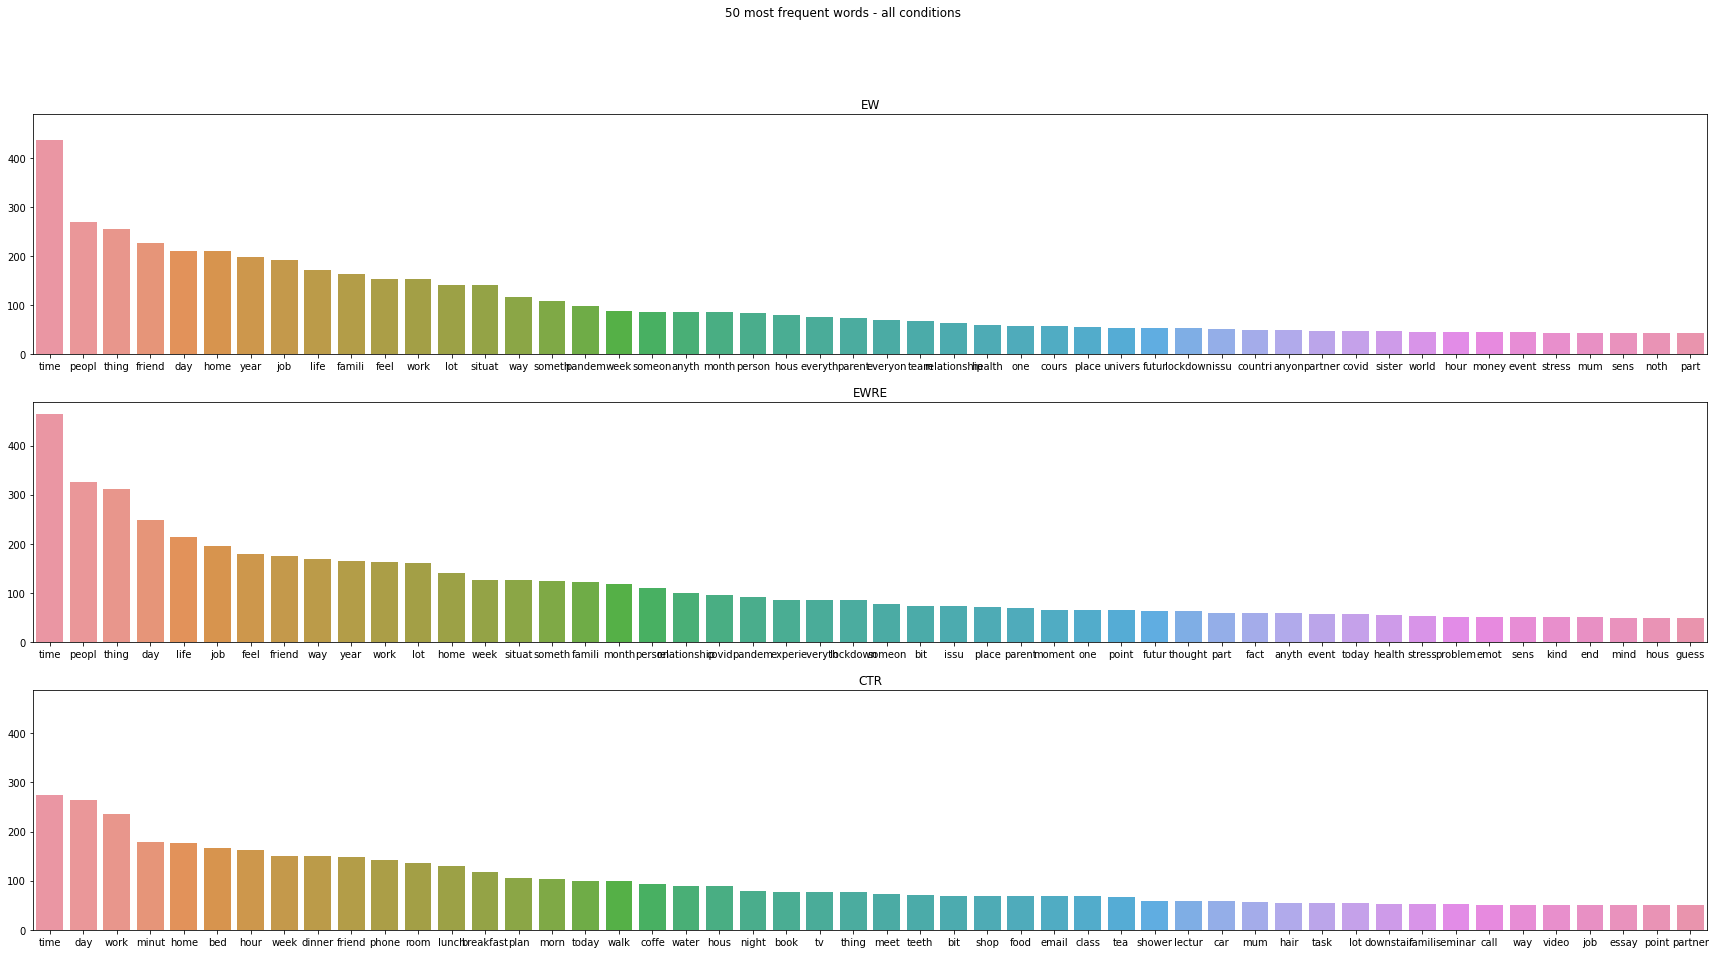

In [136]:
fig, axes = plt.subplots(3, 1, figsize=(30,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=pd.Series(ew_flattened).value_counts().index[:50], y=pd.Series(ew_flattened).value_counts()[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=pd.Series(ewre_flattened).value_counts().index[:50], y=pd.Series(ewre_flattened).value_counts()[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=pd.Series(ctr_flattened).value_counts().index[:50], y=pd.Series(ctr_flattened).value_counts()[:50])
axes[2].set_title('CTR')

As we can see, the plot has changed quite a bit, and we have a more informative mix of words, rather than just a lot of stop words.
We'll now check how similar the different writing conditions are in terms of the words used. To do this, we calculate the cosine similarity.

In [13]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

# source: https://stackoverflow.com/questions/14720324/compute-the-similarity-between-two-lists

In [14]:
# calculate cosine similarity between control and each active writing group/between the two active groups


ew_ctr = counter_cosine_similarity(Counter(ew_flattened), Counter(ctr_flattened))
ewre_ctr = counter_cosine_similarity(Counter(ewre_flattened), Counter(ctr_flattened))
ew_ewre = counter_cosine_similarity(Counter(ew_flattened), Counter(ewre_flattened))

print('The similarity between EW and CTR is: ', ew_ctr)
print('The similarity between EWRE and CTR is: ', ewre_ctr)
print('The similarity between EW and EWRE is: ', ew_ewre)

The similarity between EW and CTR is:  0.5906582452939056
The similarity between EWRE and CTR is:  0.5762576685871926
The similarity between EW and EWRE is:  0.9594697351999425


These numbers look good in terms of comparing active and control conditions, but not so great in terms of comparing the two active conditions. Not totally unexpected though, given that the instructions are similar and we have no real reason to believe that they should differ on word content. 

In [138]:
from sklearn import model_selection, feature_extraction, naive_bayes, pipeline, manifold, preprocessing, feature_selection

# get cleaned text
writing_df['writing_cleaned'] = [' '.join(f) for f in token_lists]

# split into training and test data sets
wrdf_train,wrdf_test = model_selection.train_test_split(writing_df, test_size = 0.3)

# TF-IDF vectorizer:
vectorizer_tf_idf = feature_extraction.text.TfidfVectorizer(max_features = 10000, ngram_range = (1,3))

corpus = wrdf_train['writing_cleaned']
X_train = vectorizer_tf_idf.fit_transform(corpus)
dic_vocabulary = vectorizer_tf_idf.vocabulary_


We could use the below to reduce the dimensionality of the data set by finding words that are distinct to each category. However, given the small sample size and the similarity of the EW and EW+RE condtions, this doesn't really work too well for this particular case.

In [147]:
# feature selection

y = wrdf_train['Group']
X_names = vectorizer_tf_idf.get_feature_names()
alpha = 0.95
wrdf_features = pd.DataFrame()


for cat in y.unique():
   chi2, p = feature_selection.chi2(X_train, y==cat)
   wrdf_features = wrdf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
   wrdf_features = wrdf_features.sort_values(["y","score"], 
                    ascending=[True,False])
   wrdf_features = wrdf_features[wrdf_features["score"]>alpha]
X_names = wrdf_features["feature"].unique().tolist()
   
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(wrdf_features[wrdf_features["y"]==cat]))
   print("  . top features:", ",".join(
wrdf_features[wrdf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# CTR:
  . selected features: 13
  . top features: breakfast,lunch,dinner,bed,minut,tea,peopl,teeth,tv,water
 
# EW:
  . selected features: 0
  . top features: 
 
# EWRE:
  . selected features: 0
  . top features: 
 


Based on the above, we won't be using this technique. We'll run with the full data set instead.

In [19]:
classifier = naive_bayes.MultinomialNB()

In [148]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer_tf_idf),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train,wrdf_train['Group'] )
## test
X_test = wrdf_test["writing_cleaned"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [150]:
wrdf_test['predicted'] = predicted
print('Control:' ,wrdf_test.loc[wrdf_test.Group=='CTR',['predicted']].value_counts())
print('EW:' ,wrdf_test.loc[wrdf_test.Group=='EW',['predicted']].value_counts())
print('EWRE:' ,wrdf_test.loc[wrdf_test.Group=='EWRE',['predicted']].value_counts())

Control: predicted
CTR          47
EW            1
dtype: int64
EW: predicted
EW           30
EWRE         17
dtype: int64
EWRE: predicted
EWRE         37
EW           13
dtype: int64


<ipython-input-150-763e8b70767b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrdf_test['predicted'] = predicted


We can see that the classifier does pretty well in correctly identifying the control condition.

Accuracy: 0.79
Auc: 0.9
Detail:
              precision    recall  f1-score   support

         CTR       1.00      0.98      0.99        48
          EW       0.68      0.64      0.66        47
        EWRE       0.69      0.74      0.71        50

    accuracy                           0.79       145
   macro avg       0.79      0.79      0.79       145
weighted avg       0.79      0.79      0.79       145



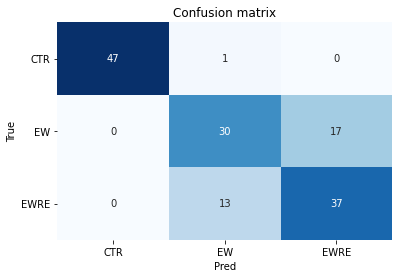

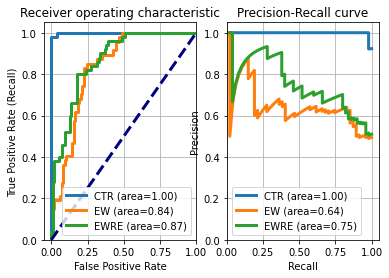

In [151]:
from sklearn import metrics

y_test = wrdf_test['Group']
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [152]:
from lime import lime_text

## select observation
i = 2
txt_instance = wrdf_test["writing_cleaned"].iloc[i]
## check true value and predicted value
print("True:", y_test.iloc[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(wrdf_train['Group']))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: EW --> Pred: EW | Prob: 0.49


In [153]:
def get_lst_corpus(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
       # lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_words)
    return lst_corpus

def get_ngrams(lcorpus, min_count, thresh):
    """
    detect ngrams
    params:
    lcorpus: list of lists representing input corpus
    min_count, thresh - parameters to pass to gensim Phrases

    """
    bigrams_det = gensim.models.phrases.Phrases(lcorpus, min_count =min_count, threshold = thresh)
    bigrams_det = gensim.models.phrases.Phraser(bigrams_det)
    trigrams_det = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=min_count, threshold=thresh)
    trigrams_det = gensim.models.phrases.Phraser(trigrams_det)
    return bigrams_det, trigrams_det

In [154]:
from gensim import models
corpus = wrdf_train['writing_cleaned']

## create list of lists of unigrams
lst_corpus = get_lst_corpus(corpus)


## detect bigrams and trigrams
# note: min_count: ignore all bigrams/trigrams with total count lower than min_count
# threshold: the higher this value, the fewer ngrams will be created
# min_count and threshold are hyperparameters and likely need tuning. Starting off with the defaults.
bigrams_detector, trigrams_detector = get_ngrams(lst_corpus, min_count = 5, thresh = 10)
#bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count = 5, threshold = 10)
#bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
#trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
#trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [155]:
# fit
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size = 300)
# vector size choice based on:https://datascience.stackexchange.com/questions/51404/word2vec-how-to-choose-the-embedding-size-parameter


C:\Users\luzia.troebinger\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


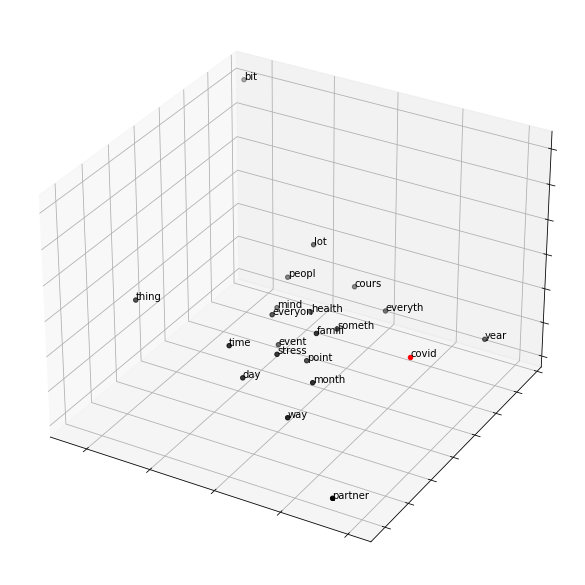

In [157]:
word = "covid"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [116]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [117]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")


In [118]:
i = 0
## list of text: ["I like this", ...]
len_txt = len(wrdf_train['writing_cleaned'].iloc[i].split())
print("from: ", wrdf_train['writing_cleaned'].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", wrdf_train["writing_cleaned"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[wrdf_train["writing_cleaned"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  topic fact insight prospect issu feel read caus suffer distress yesterday sort idea way issu way distress futur futur realiz live break work time world ye fact month freedom joy idea presenc mind idea year futur declin think train life mission space privilag thing mission earth life shop bill famili someth month syndrom peopl holiday break week case eleph room mind everyth work life rest life field life someth ok someth architectur passion time societi doubt point someth societi way toward societi ye firm point confus skill job confus confus distress | len: 91
to:  [ 169   63 1169  270   35   12  148  437  750  380   72  228  129   13
   35] | len: 15
check:  topic  -- idx in vocabulary --> 169
vocabulary:  {'time': 1, 'thing': 2, 'day': 3, 'peopl': 4, 'friend': 5} ... (padding element, 0)


In [119]:
test_corpus = wrdf_test['writing_cleaned']

lst_test_corpus = get_lst_corpus(test_corpus)

lst_test_corpus = list(bigrams_detector[lst_test_corpus])
lst_test_corpus = list(trigrams_detector[lst_test_corpus])

lst_test_text2seq = tokenizer.texts_to_sequences(lst_test_corpus)
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen = 15, padding = 'post', truncating = 'post')


In [122]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [123]:
word = 'covid'
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 30 |idx
embeddings[idx]: (300,) |vector


In [124]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x
## input
x_in = layers.Input(shape=(15,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)## apply attention
x = attention_layer(x, neurons=15)## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      1071300     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

In [128]:
## encode y
y_train = wrdf_train['Group']
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [ ]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
    ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [258]:
def main():
    ntopic = 10
    method = 'TFIDF'
    #parser = argparse.ArgumentParser(description='contextual_topic_identification tm_test:1.0')

    #parser.add_argument('--fpath', default='/kaggle/working/train.csv')
    #parser.add_argument('--ntopic', default=10,)
    #parser.add_argument('--method', default='TFIDF')
    #parser.add_argument('--samp_size', default=20500)
    
    #args = parser.parse_args()

    #data = writing_df.writing 

    #sentences, token_lists, idx_in = preprocess(data)

    tm = Topic_Model(k = ntopic, method = method)
    tm.fit(sentences,token_lists)

        

In [ ]:
main()